In [9]:
%reset -f
import gc
gc.collect()

from math import *
import numpy as np
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

2024-03-26 16:09:06.738063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Explore the real simulated TODs sample (Samantha data)
dir_name = '../data'
data_source = 'sam' # gc, sam, gui, gui_basic

time_bins = 1060

if data_source == 'sam':

    data_file = '/full_TOD.npy' # homemade_TOD.npy, full_TOD.npy, Guillermo_TOD.npy
    
    with open(dir_name + data_file, 'rb') as file:
        TOD_file = np.load(file, allow_pickle=True)
        print("Download file shape : ",TOD_file.shape)

    NTODs = TOD_file.shape[2]//time_bins
    
    TODs = np.array([TOD_file[:, :, 0:time_bins]])
    print("Splitted TODs shape : ", TODs.shape)
        
    for i in range(1, NTODs):
        next_TOD = np.array([TOD_file[:, :, i*time_bins:(i+1)*time_bins]])
        TODs = np.append(TODs, next_TOD, axis=0)

    # Load the real simulated TODs (Samantha data)
    time_steps = TODs[:, 0, :, :]
    real_TODs = TODs[:, 1, :, :]

if data_source == 'gui_basic':

    data_file = '/Guillermo_TOD_basic.npy' # homemade_TOD.npy, full_TOD.npy, Guillermo_TOD.npy
    
    with open(dir_name + data_file, 'rb') as file:
        time_steps = np.load(file, allow_pickle=True)
        real_TODs = np.load(file, allow_pickle=True)

if data_source == 'gui_digital':

    data_file = '/Guillermo_TOD_digital.npy' # homemade_TOD.npy, full_TOD.npy, Guillermo_TOD.npy
    
    with open(dir_name + data_file, 'rb') as file:
        time_steps = np.load(file, allow_pickle=True)
        real_TODs = np.load(file, allow_pickle=True)
    
print(f'The TODs sample loaded has the shape: {real_TODs.shape}')

Download file shape :  (2, 12, 843760)
Splitted TODs shape :  (1, 2, 12, 1060)
The TODs sample loaded has the shape: (796, 12, 1060)


Real TODs have the shape:  (796, 12, 1060)


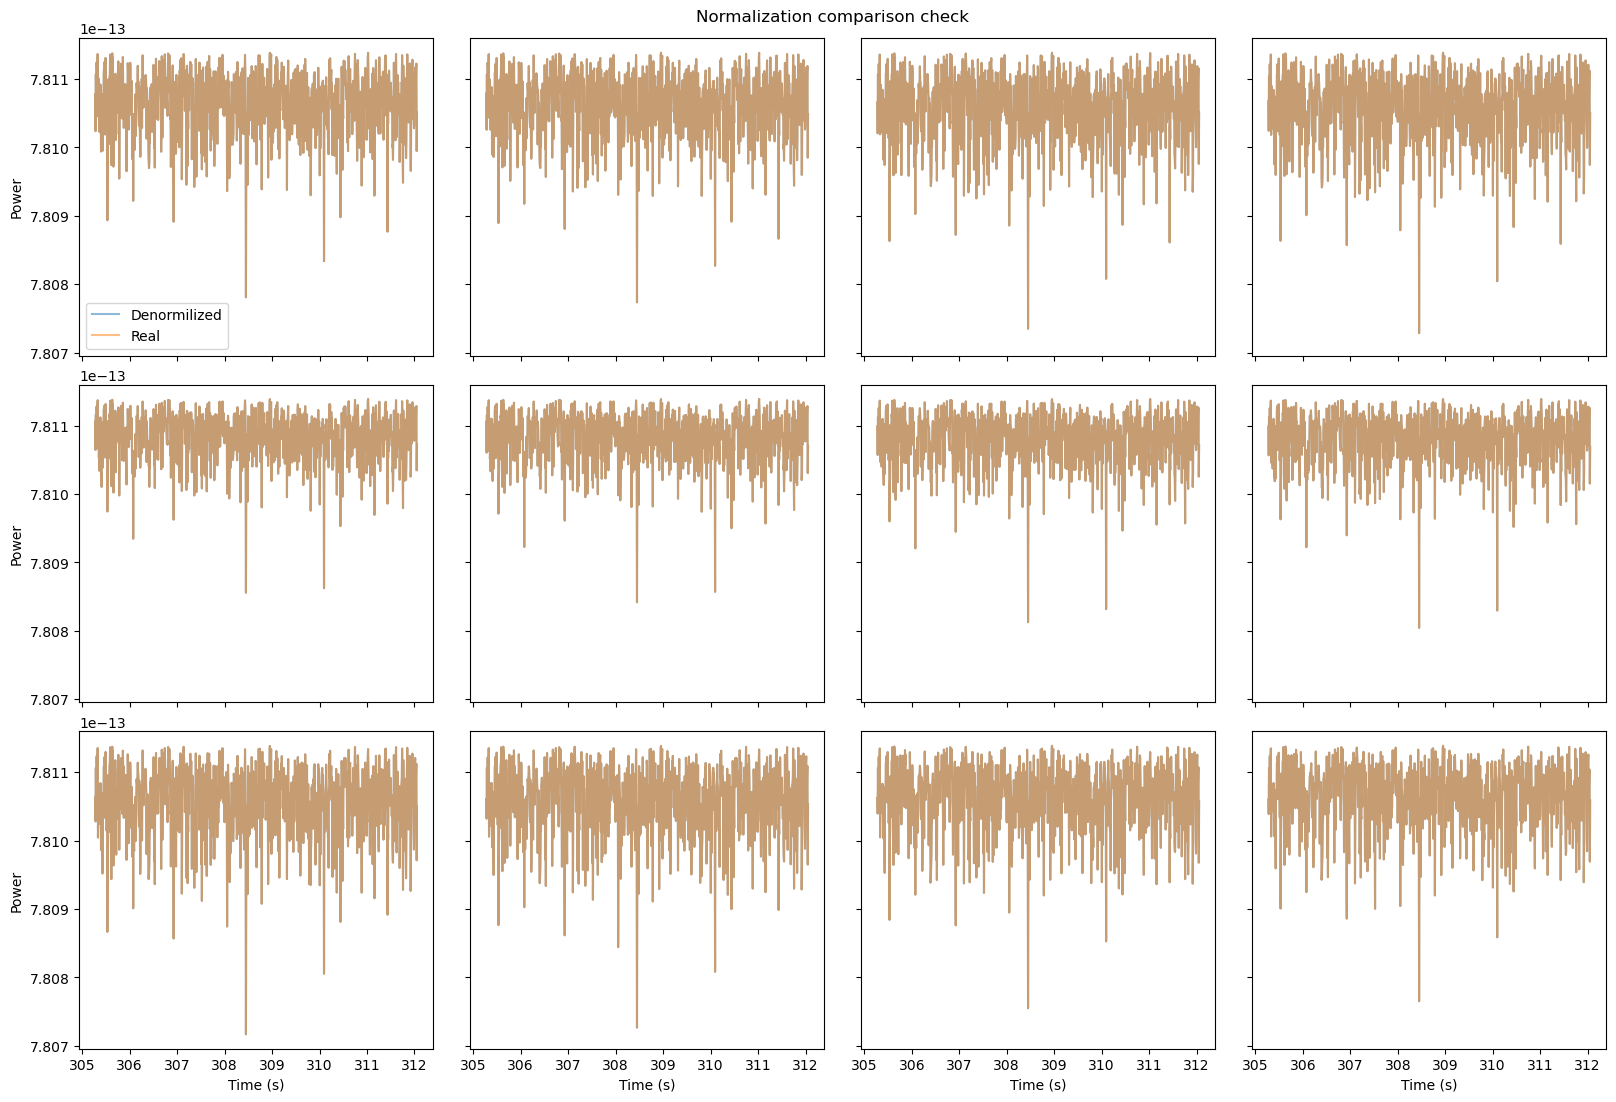

In [3]:
# Normalization of the TODs and split in training and validation samples

def normalize(sample):

    mins = np.repeat(np.min(sample, axis=2), sample.shape[2], axis=1)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=2), sample.shape[2], axis=1)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):

    sample = mins + (maxs-mins)*(sample)
  
    return sample

# Normalization and split of data in training and test datasets
print('Real TODs have the shape: ', real_TODs.shape)

val_split = 0.1
norm_TODs, mins, maxs = normalize(real_TODs)
TODs_train, TODs_val = train_test_split(norm_TODs, test_size=val_split)

# Plot test of normalization and denormalization
rows = int(np.sqrt(real_TODs.shape[1]))
cols = real_TODs.shape[1]//rows

if rows == 1:
    fig, ax = plt.subplots(figsize = (5,5))
    fig.suptitle(f'Normalization comparison check')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])
    
    ax.set_ylabel('Power', loc='center')
    ax.set_xlabel('Time (s)', loc='center')
    denorm_TODs_train = denormalize(norm_TODs[TOD_id,0,:], mins, maxs)
    ax.plot(time_steps[TOD_id,0,:], denorm_TODs_train[TOD_id,0,:], label='Denormilized')
    ax.plot(time_steps[TOD_id,0,:], real_TODs[TOD_id,0,:], label='Normilized')
    ax.legend()

else:
    fig, ax = plt.subplots(rows, cols, figsize = (16,11), sharex=True, sharey=True)
    fig.suptitle(f'Normalization comparison check')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])

    for i in range (rows):
        ax[i, 0].set_ylabel('Power', loc='center')
        for k in range(cols):
            ax[rows-1, k].set_xlabel('Time (s)', loc='center')
            denorm_TODs_train = denormalize(norm_TODs[TOD_id,k+i*cols,:], mins, maxs)
            ax[i,k].plot(time_steps[TOD_id,k+i*cols,:], denorm_TODs_train[TOD_id,k+i*cols,:], label='Denormilized', alpha=0.5)
            ax[i,k].plot(time_steps[TOD_id,k+i*cols,:], real_TODs[TOD_id,k+i*cols,:], label='Real', alpha=0.5)
    
    ax[0,0].legend()

plt.show()
plt.close()

In [4]:
# Reshape TODs to NN format
time_steps = np.swapaxes(time_steps, 1, 2)
TODs_train = np.swapaxes(TODs_train, 1, 2)
TODs_val = np.swapaxes(TODs_val, 1, 2)

print(time_steps.shape)
print(TODs_train.shape)
print(TODs_val.shape)

(796, 1060, 12)
(716, 1060, 12)
(80, 1060, 12)


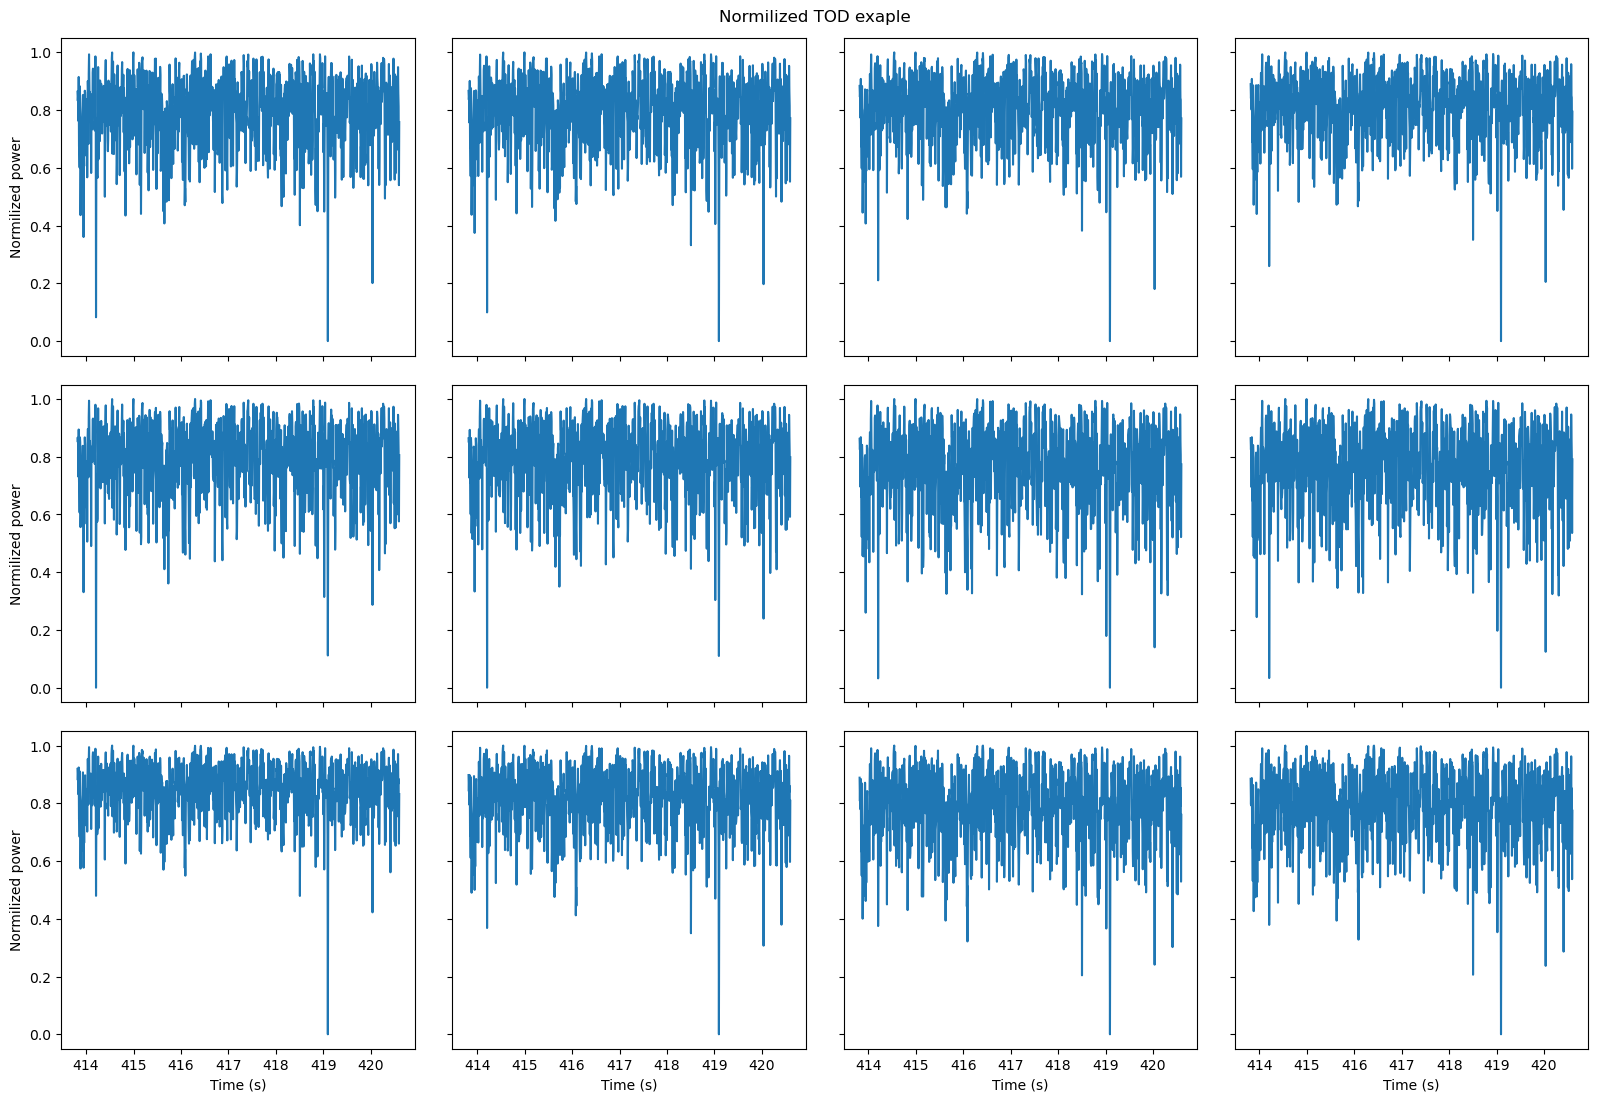

In [7]:
# Test the resample of the data
if rows == 1:
    fig, ax = plt.subplots(figsize = (5,5))
    fig.suptitle(f'Normilized TOD exaple')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])
    
    ax.set_ylabel('Normilized power', loc='center')
    ax.set_xlabel('Time (s)', loc='center')
    ax.plot(time_steps[TOD_id,:,0], TODs_train[TOD_id,:,0])

else:
    fig, ax = plt.subplots(rows, cols, figsize = (16,11), sharex=True, sharey=True)
    fig.suptitle(f'Normilized TOD exaple')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])

    for i in range (rows):
        ax[i, 0].set_ylabel('Normilized power', loc='center')
        for k in range(cols):
            ax[rows-1, k].set_xlabel('Time (s)', loc='center')
            ax[i,k].plot(time_steps[TOD_id,:,k+i*cols], TODs_train[TOD_id,:,k+i*cols])
    
plt.show()
plt.close()

# Save the real simulated TODs
if data_source == 'sam':
    save_file = '/real_TOD.npy' # real_TOD.npy, gui_TOD.npy

if data_source == 'gui_basic':
    save_file = '/gui_TOD_basic.npy'

if data_source == 'gui_digital':
    save_file = '/gui_TOD_digital.npy'

with open(dir_name + save_file, 'wb') as file:
    np.save(file, time_steps)
    np.save(file, mins)
    np.save(file, maxs)
    #np.save(file, norm_TODs)
    np.save(file, TODs_train)
    np.save(file, TODs_val)

In [15]:
# Normalization sxes test
sample = np.array([[[1,2],[3,4]],[[5,6],[8,9]]])
print(sample.shape)
print(sample)

mins = np.repeat(np.min(sample, axis=2), sample.shape[2], axis=1)
mins = mins.reshape(sample.shape)
maxs = np.repeat(np.max(sample, axis=2), sample.shape[2], axis=1)
maxs = maxs.reshape(sample.shape)

print('mins:\n', mins)
print('maxs:\n', maxs)

norm = (sample - mins)/(maxs-mins)
print(norm)

mins = np.repeat(tf.math.reduce_min(sample, axis=1), sample.shape[1], axis=0)
mins = mins.reshape(sample.shape)
maxs = np.repeat(tf.math.reduce_max(sample, axis=1), sample.shape[1], axis=0)
maxs = maxs.reshape(sample.shape)

print('mins:\n', mins)
print('maxs:\n', maxs)

norm = (sample - mins)/(maxs-mins)
print(norm)

(2, 2, 2)
[[[1 2]
  [3 4]]

 [[5 6]
  [8 9]]]
mins:
 [[[1 1]
  [3 3]]

 [[5 5]
  [8 8]]]
maxs:
 [[[2 2]
  [4 4]]

 [[6 6]
  [9 9]]]
[[[0. 1.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]]]
mins:
 [[[1 2]
  [1 2]]

 [[5 6]
  [5 6]]]
maxs:
 [[[3 4]
  [3 4]]

 [[8 9]
  [8 9]]]
[[[0. 0.]
  [1. 1.]]

 [[0. 0.]
  [1. 1.]]]


## NORMILIZTION AXES NOTE
To have the correct nomalization for each individual TOD and bolometer independent ones need to use the function:

```python
def normalize(sample):

    mins = np.repeat(np.min(sample, axis=AX1), sample.shape[AX1], axis=AX2)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=AX1), sample.shape[AX1], axis=AX2)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):

    sample = mins + (maxs-mins)*(sample)
  
    return sample
```

with
- AX1 = 2, AX2 = 1 if the data have the shape of Samantha file
- AX1 = 2, AX2 = 1 if the data have the shape of NN inputs